In [ ]:
from PyISV.neural_network import NeuralNetwork 
from collections import OrderedDict
from tqdm import tqdm 

import matplotlib.pyplot as plt
import numpy as np
import os
import re

import torch

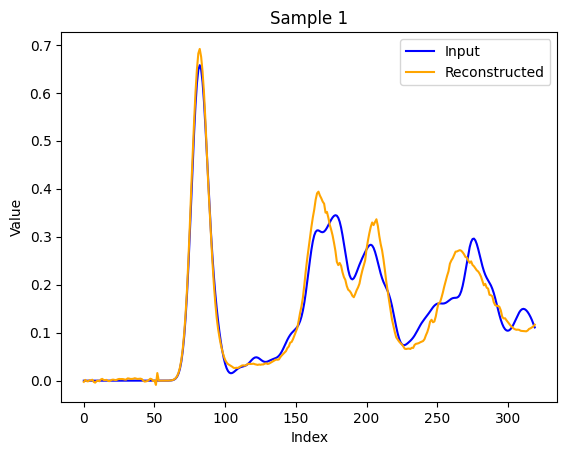

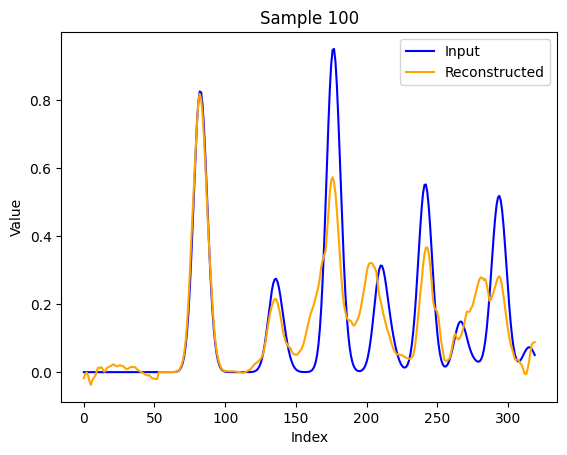

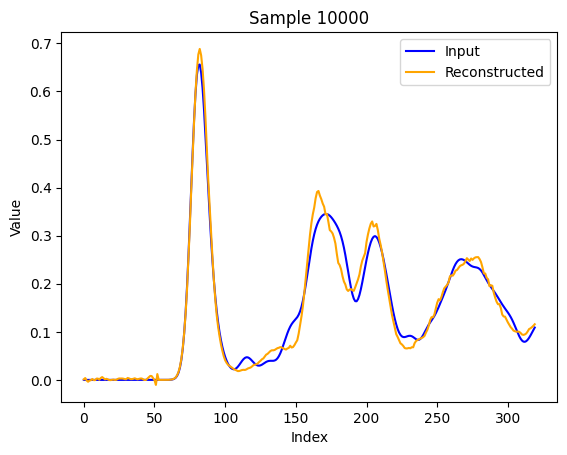

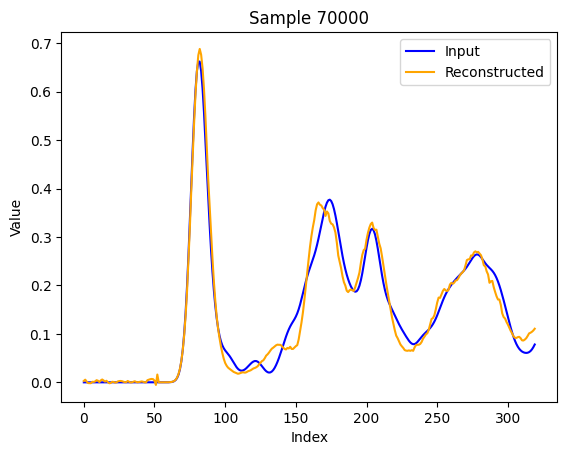

In [ ]:
# Load normalization parameters
input_scaler_subval = np.load("../norm_vals/input_autoen_scaler_subval.npy")
input_scaler_divval = np.load("../norm_vals/input_autoen_scaler_divval.npy")
output_scaler_subval = np.load("../norm_vals/target_autoen_scaler_subval.npy")
output_scaler_divval = np.load("../norm_vals/target_autoen_scaler_divval.npy")

# -- Load the architecture of the model -- #
with open('../models/autoencoder_architecture.txt') as f:
    lines = f.read()

# Extract model parameters from the architecture
encoder_channels = [int(m.group(2)) for m in re.finditer(r'Conv1d\((\d+), (\d+),', lines)][:-1]
decoder_channels = [int(m.group(2)) for m in re.finditer(r'ConvTranspose1d\((\d+), (\d+),', lines)]
embed_dim = int(re.search(r'Linear\(in_features=\d+, out_features=(\d+),', lines).group(1))
activation_fn = torch.nn.ReLU if 'ReLU' in lines else None
use_pooling = ('MaxPool1d' in lines) or ('Upsample' in lines)
kernel_size = [int(m.group(1)) for m in re.finditer(r'kernel_size=\((\d+),\)', lines)][0]
input_shape = (int(re.search(r'Conv1d\((\d+),', lines).group(1)),
               int(re.search(r'Upsample\(size=(\d+),', lines).group(1)))

model = NeuralNetwork(
    model_type="autoencoder",
    input_shape=input_shape,
    embed_dim=embed_dim,
    encoder_channels=encoder_channels,
    decoder_channels=decoder_channels,
    activation_fn=activation_fn,
    kernel_size=kernel_size,
    use_pooling=use_pooling,
    device="cpu",
)

# -- Load the saved state dictionary -- #
model_path = "../models/best_autoencoder_model.pt"  # Replace with your model path
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
state_dict = checkpoint["model_state_dict"]

# -- Load the state dictionary into the model -- #
# If the  model was trained and saved using torch.nn.DataParallel (DP) or 
# torch.nn.parallel.DistributedDataParallel (DDP), the model is wrapped and 
# a module. prefix is set to all parameter keys in the state dict. 
# When the state dict is loaded into a model not wrapped with DDP/DataParallel, 
# the keys do not match. So we need to remove the module. prefix from the keys.

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "") if k.startswith("module.") else k
    new_state_dict[new_key] = v
model.load_state_dict(new_state_dict)

# Set the model to evaluation mode
model.eval()

# Load the input data
input_data_path = "../data/RDFs/rdf_images.pt"  # Replace with your input data path
input_data = torch.load(input_data_path).float()

# Create a folder to save reconstructed outputs
output_folder = "../data/reconstructed_outputs"
os.makedirs(output_folder, exist_ok=True)

# Reconstruct outputs
with torch.no_grad():
    for i in [1,100,10000,70000]:  # Process up to 5 samples
        input_signal = input_data[i].unsqueeze(0)  # Add batch dimension
        reconstructed_signal, _ = model(input_signal)  # Extract the reconstructed signal

        # pytorch tensor to numpy array
        input_signal = input_signal.detach().cpu().numpy()
        reconstructed_signal = reconstructed_signal.detach().cpu().numpy()
        reconstructed_signal = (reconstructed_signal * output_scaler_divval) + output_scaler_subval

        # Plot and save the input and reconstructed signals
        fig, ax = plt.subplots()
        ax.plot(input_signal.squeeze(), label="Input", color="blue")
        ax.plot(reconstructed_signal.squeeze(), label="Reconstructed", color="orange")
        ax.legend()
        ax.set_title(f"Sample {i}")
        ax.set_xlabel("Index")
        ax.set_ylabel("Value")

        output_path = os.path.join(output_folder, f"sample_{i}.png")
        #fig.savefig(output_path)

Input shape: torch.Size([72000, 1, 320])
Validation set size: 14400


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]/leonardo_scratch/large/userexternal/fraseraf/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

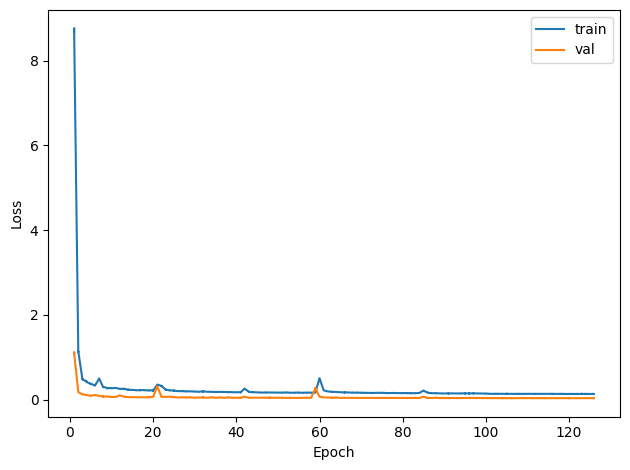

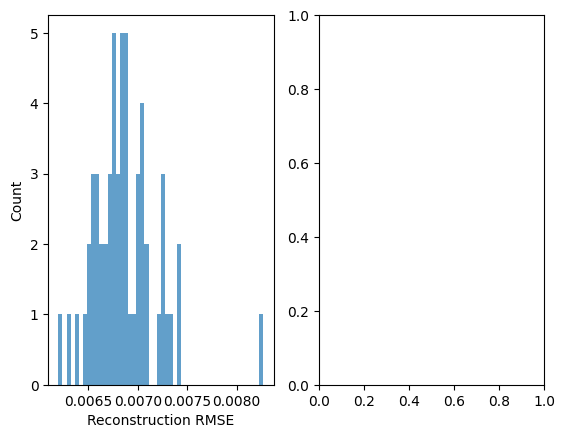

In [ ]:
import pandas as pd
from openTSNE import TSNE
from torch.utils.data import DataLoader
from PyISV.train_utils import PreloadedDataset, MSELoss

def plot_loss_curve(stats_file, out_dir):
    df = pd.read_csv(stats_file)
    fig, ax = plt.subplots(1,1)
    ax.plot(df['epoch'], df['train_loss'], label='train')
    ax.plot(df['epoch'], df['val_loss'],   label='val')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.legend(); plt.tight_layout()
    fig.savefig(os.path.join(out_dir, 'loss_curve.png'))

def evaluate_reconstructions(model, loader, device, loss_fn, out_dir):
    model.eval()
    all_errors = []
    embeddings = []

    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Evaluating", leave=False):
            x = x.to(device)
            recon, latent = model(x)
            errs = loss_fn(recon, x).detach().cpu().numpy()
            all_errors.append(np.atleast_1d(errs))

            # Flatten latent except batch dimension
            embeddings.append(latent.cpu().numpy().reshape(latent.shape[0], -1))
    errors = np.concatenate(all_errors)
    embeds = np.concatenate(embeddings, axis=0)


    # Histogram of errors
    fig, axes = plt.subplots(1,2)
    axes[0].hist(errors, bins=50, alpha=0.7)
    axes[0].set_xlabel('Reconstruction RMSE'); axes[0].set_ylabel('Count')

    # Run t-SNE (openTSNE is much faster)
    tsne = TSNE(n_jobs=4, random_state=0)  # n_jobs sets the number of CPU cores
    z2d = tsne.fit(embeds)
    axes[1].scatter(z2d[:,0], z2d[:,1], s=5, alpha=0.6)
    axes[1].set_title('Latent space t-SNE'); plt.tight_layout()
    
    fig.savefig(os.path.join(out_dir, 'latent_tsne.png'))

    return errors, embeds

# -- Create output directory for evaluation plots -- #
output_folder = "../outputs/evaluation"
os.makedirs(output_folder, exist_ok=True)

# -- Plot training curves -- #
plot_loss_curve("../stats/train_autoencoder_stats.txt", output_folder)

# -- Load the input data for evaluation -- #
path = "../data/RDFs/rdf_images.pt"
target_path = None
inp = torch.load(path).float()
tgt = torch.load(target_path).float() if target_path else inp.clone()
print(f"Input shape: {inp.shape}")

# -- Dataset and DataLoader for evaluation -- #
from sklearn.model_selection import train_test_split
X_train, X_val, _, _ = train_test_split(inp, tgt,
    train_size=0.8,
    random_state=42
)
val_dataset = PreloadedDataset(X_val, X_val, norm_inputs=True, norm_targets=True)
val_loader = DataLoader(val_dataset, batch_size=256,  shuffle=False, num_workers=4, pin_memory=True)
print(f"Validation set size: {len(val_loader.dataset)}")

# evaluate
loss_fn = MSELoss()
errors, embeds = evaluate_reconstructions(model, val_loader, "cpu", loss_fn, "../outputs/evaluation")

# -- Save the errors and embeddings -- #
np.save(os.path.join("../outputs/evaluation", 'recon_errors.npy'), errors)
np.save(os.path.join("../outputs/evaluation", 'latent_embeddings.npy'), embeds)